# Data Pre-Processing

In [51]:
import collections
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os
from sklearn.metrics import roc_curve, auc

# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, collections.Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)

# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low

In [52]:
import sklearn.feature_extraction.text as sk_text
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from pandas import Series
%matplotlib inline
import json
import csv
import pandas as pd

In [53]:
filename_read = 'Stock_Price_MAX.csv'
df = pd.read_csv(filename_read, na_values=['NA','?'])

In [54]:
df.head()

,Date,Open,High,Low,Close,Adj_Close,Volume
0,2000-03-27,3.812500,4.156250,3.812500,4.125000,4.125000,3675600
1,2000-03-28,4.125000,4.125000,4.000000,4.015625,4.015625,1077600
2,2000-03-29,4.000000,4.031250,3.953125,4.000000,4.000000,437200
3,2000-03-30,4.000000,4.000000,3.843750,3.843750,3.843750,1883600
4,2000-03-31,3.734375,3.734375,3.390625,3.390625,3.390625,7931600


In [55]:
df[df.isnull().any(axis=1)]

,Date,Open,High,Low,Close,Adj_Close,Volume


In [56]:
df.drop(columns=['Date','Adj_Close'],inplace=True)

# Feature Normalization using min_max function

In [57]:
max = df['Volume'].max()
min = df['Volume'].min()
df['normalized_Volume'] = (df['Volume'] - min)/(max - min)

In [58]:
max = df['Open'].max()
min = df['Open'].min()
df['normalized_Open'] = (df['Open'] - min)/(max - min)

In [59]:
max = df['High'].max()
min = df['High'].min()
df['normalized_High'] = (df['High'] - min)/(max - min)

In [60]:
max = df['Low'].max()
min = df['Low'].min()
df['normalized_Low'] = (df['Low'] - min)/(max - min)

In [61]:
for i in df.columns:
    print(i, df[i].min(), df[i].max(), df[i].unique().shape)

Open 3.296875 121.08000200000001 (3280,)
High 3.390625 121.75 (3405,)
Low 3.0 120.16999799999999 (3437,)
Close 3.25 121.360001 (3484,)
Volume 190400 46412600 (3653,)
normalized_Volume 0.0 1.0 (3653,)
normalized_Open 0.0 1.0 (3280,)
normalized_High 0.0 1.0 (3405,)
normalized_Low 0.0 1.0 (3437,)


Open


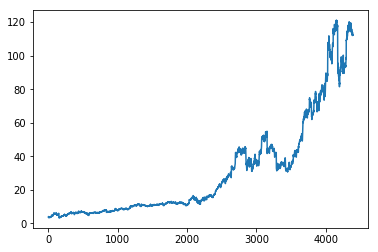

High


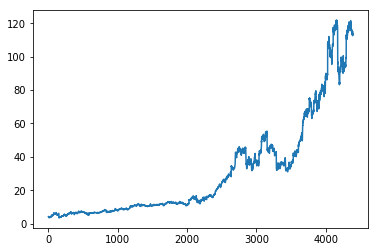

Low


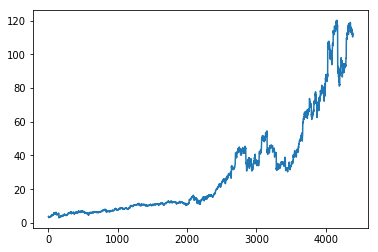

Close


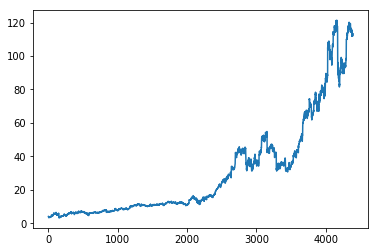

Volume


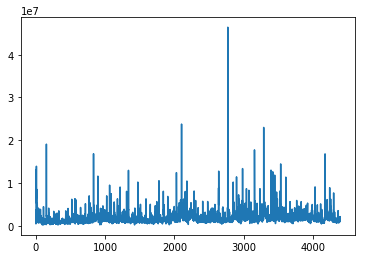

normalized_Volume


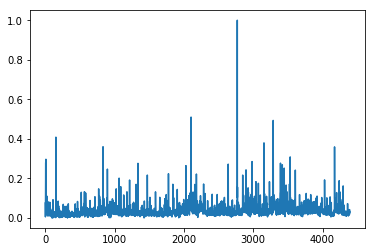

normalized_Open


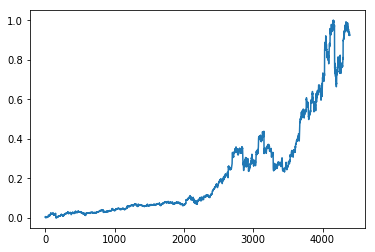

normalized_High


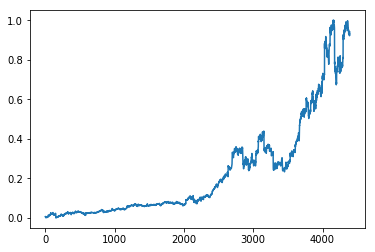

normalized_Low


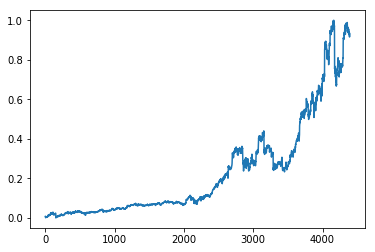

In [62]:
for i in df.columns:
    print(i)
    df[i].plot()
    plt.show()


In [63]:
df.drop(columns=['Volume','High','Low','Open'],inplace=True)

In [65]:
df.head()

,Close,normalized_Volume,normalized_Open,normalized_High,normalized_Low
0,4.125000,0.075401,0.004378,0.006469,0.006934
1,4.015625,0.019194,0.007031,0.006205,0.008535
2,4.000000,0.005339,0.005970,0.005413,0.008135
3,3.843750,0.036632,0.005970,0.005149,0.007201
4,3.390625,0.167478,0.003714,0.002904,0.003334


In [64]:
def print_reg_eval(pred,true):
    score = metrics.mean_squared_error(pred,true)
    print("Final score (MSE): {}".format(score))
    score = np.sqrt(metrics.mean_squared_error(pred,true))
    print("Final score (RMSE): {}".format(score))
    chart_regression(pred.flatten(),true)

# Fully Connected Artificial Neural Network

Train on 3074 samples, validate on 1318 samples
Epoch 1/100
 - 19s - loss: 1810.0221 - val_loss: 1628.8739
Epoch 2/100
 - 1s - loss: 1465.1760 - val_loss: 1049.6050
Epoch 3/100
 - 1s - loss: 702.5046 - val_loss: 330.8895
Epoch 4/100
 - 1s - loss: 200.0428 - val_loss: 124.6563
Epoch 5/100
 - 1s - loss: 88.1374 - val_loss: 61.2832
Epoch 6/100
 - 1s - loss: 39.7827 - val_loss: 24.2349
Epoch 7/100
 - 1s - loss: 13.8317 - val_loss: 6.9751
Epoch 8/100
 - 1s - loss: 3.5829 - val_loss: 1.5368
Epoch 9/100
 - 1s - loss: 0.7395 - val_loss: 0.2609
Epoch 10/100
 - 1s - loss: 0.2189 - val_loss: 0.1716
Epoch 11/100
 - 1s - loss: 0.1696 - val_loss: 0.1466
Epoch 12/100
 - 1s - loss: 0.1505 - val_loss: 0.1336
Epoch 13/100
 - 1s - loss: 0.1372 - val_loss: 0.1233
Epoch 14/100
 - 1s - loss: 0.1281 - val_loss: 0.1170
Epoch 15/100
 - 1s - loss: 0.1214 - val_loss: 0.1113
Epoch 16/100
 - 1s - loss: 0.1160 - val_loss: 0.1064
Epoch 17/100
 - 1s - loss: 0.1119 - val_loss: 0.1016
Epoch 18/100
 - 1s - loss: 0.1084 

Epoch 00021: early stopping
Final score (MSE): 0.08358719199895859
Final score (RMSE): 0.28911450505256653


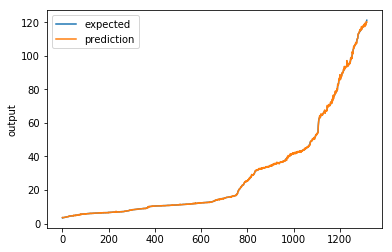

In [108]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import os
import io
import requests
from sklearn import metrics

x,y = to_xy(df, 'Close')
x_train_ann, x_test_ann, y_train_ann, y_test_ann = train_test_split(x, y, test_size=0.3, random_state=42)
checkpointer = ModelCheckpoint(filepath="ann/best_weights_ann.hdf5", verbose=0, save_best_only=True) # save best model
for i in range(5):
    model = Sequential()
    model.add(Dense(30, input_dim=x.shape[1], activation='relu')) # Hidden 1
    model.add(Dense(15, activation='relu')) # Hidden 2
    model.add(Dense(1)) # Output
    model.compile(loss='mean_squared_error', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=2, mode='auto')
    model.fit(x_train_ann, y_train_ann, validation_data=(x_test_ann,y_test_ann), callbacks=[monitor,checkpointer], verbose=2, epochs=100)  

model.load_weights('ann/best_weights_ann.hdf5')
pred = model.predict(x_test_ann)
print_reg_eval(pred,y_test_ann)

# Hypertuning on parameters for Fully Connected Network

Train on 3074 samples, validate on 1318 samples
Epoch 1/100
 - 12s - loss: 1752.3991 - val_loss: 1582.0003
Epoch 2/100
 - 1s - loss: 1612.8541 - val_loss: 1487.9736
Epoch 3/100
 - 1s - loss: 1527.2794 - val_loss: 1415.2481
Epoch 4/100
 - 1s - loss: 1451.0999 - val_loss: 1347.6201
Epoch 5/100
 - 1s - loss: 1381.8845 - val_loss: 1281.7572
Epoch 6/100
 - 1s - loss: 1307.5737 - val_loss: 1212.3064
Epoch 7/100
 - 1s - loss: 1238.6431 - val_loss: 1157.0860
Epoch 8/100
 - 1s - loss: 1183.3229 - val_loss: 1111.3239
Epoch 9/100
 - 1s - loss: 1137.1011 - val_loss: 1072.9431
Epoch 10/100
 - 1s - loss: 1092.9897 - val_loss: 1032.8513
Epoch 11/100
 - 1s - loss: 1053.2215 - val_loss: 1000.2178
Epoch 12/100
 - 1s - loss: 1017.1312 - val_loss: 972.4801
Epoch 13/100
 - 1s - loss: 988.6501 - val_loss: 951.4114
Epoch 14/100
 - 1s - loss: 967.0620 - val_loss: 935.7246
Epoch 15/100
 - 1s - loss: 947.6356 - val_loss: 920.4505
Epoch 16/100
 - 1s - loss: 931.1461 - val_loss: 909.5667
Epoch 17/100
 - 1s - loss

Epoch 45/100
 - 1s - loss: 207.0336 - val_loss: 199.2760
Epoch 46/100
 - 1s - loss: 194.7771 - val_loss: 187.6844
Epoch 47/100
 - 1s - loss: 183.5434 - val_loss: 176.8967
Epoch 48/100
 - 1s - loss: 173.1314 - val_loss: 166.8513
Epoch 49/100
 - 1s - loss: 163.3963 - val_loss: 157.6913
Epoch 50/100
 - 1s - loss: 154.3283 - val_loss: 148.9124
Epoch 51/100
 - 1s - loss: 145.7934 - val_loss: 140.6245
Epoch 52/100
 - 1s - loss: 137.7395 - val_loss: 132.9464
Epoch 53/100
 - 1s - loss: 130.1822 - val_loss: 125.6441
Epoch 54/100
 - 1s - loss: 123.0538 - val_loss: 118.7436
Epoch 55/100
 - 1s - loss: 116.3251 - val_loss: 112.2838
Epoch 56/100
 - 1s - loss: 110.0037 - val_loss: 105.9873
Epoch 57/100
 - 1s - loss: 103.9391 - val_loss: 100.1162
Epoch 58/100
 - 1s - loss: 98.2296 - val_loss: 94.4238
Epoch 59/100
 - 1s - loss: 92.7738 - val_loss: 89.1115
Epoch 60/100
 - 1s - loss: 87.5886 - val_loss: 84.1300
Epoch 61/100
 - 1s - loss: 82.6654 - val_loss: 79.2577
Epoch 62/100
 - 1s - loss: 77.9555 - va

Epoch 91/100
 - 1s - loss: 12.3337 - val_loss: 11.4131
Epoch 92/100
 - 1s - loss: 11.4023 - val_loss: 10.5587
Epoch 93/100
 - 0s - loss: 10.5265 - val_loss: 9.7628
Epoch 94/100
 - 1s - loss: 9.7070 - val_loss: 9.0239
Epoch 95/100
 - 1s - loss: 8.9687 - val_loss: 8.3069
Epoch 96/100
 - 1s - loss: 8.2236 - val_loss: 7.6389
Epoch 97/100
 - 1s - loss: 7.5571 - val_loss: 7.0293
Epoch 98/100
 - 1s - loss: 6.9292 - val_loss: 6.4335
Epoch 99/100
 - 1s - loss: 6.3427 - val_loss: 5.9064
Epoch 100/100
 - 1s - loss: 5.8033 - val_loss: 5.4252
Train on 3074 samples, validate on 1318 samples
Epoch 1/100
 - 13s - loss: 1746.4439 - val_loss: 1568.9256
Epoch 2/100
 - 1s - loss: 1590.3201 - val_loss: 1460.6715
Epoch 3/100
 - 1s - loss: 1490.6143 - val_loss: 1372.8537
Epoch 4/100
 - 1s - loss: 1399.8485 - val_loss: 1293.3652
Epoch 5/100
 - 1s - loss: 1321.0344 - val_loss: 1228.0551
Epoch 6/100
 - 1s - loss: 1256.8100 - val_loss: 1173.7723
Epoch 7/100
 - 1s - loss: 1202.1915 - val_loss: 1127.8255
Epoch 8/1

 - 1s - loss: 287.5966 - val_loss: 277.5367
Epoch 36/100
 - 1s - loss: 272.8071 - val_loss: 263.3386
Epoch 37/100
 - 1s - loss: 258.6805 - val_loss: 249.5730
Epoch 38/100
 - 1s - loss: 245.1439 - val_loss: 236.4447
Epoch 39/100
 - 1s - loss: 232.2042 - val_loss: 223.8650
Epoch 40/100
 - 1s - loss: 219.4327 - val_loss: 211.7521
Epoch 41/100
 - 1s - loss: 207.4450 - val_loss: 200.1652
Epoch 42/100
 - 1s - loss: 195.6316 - val_loss: 188.8442
Epoch 43/100
 - 1s - loss: 184.9297 - val_loss: 178.6998
Epoch 44/100
 - 1s - loss: 174.8420 - val_loss: 168.8398
Epoch 45/100
 - 1s - loss: 165.2383 - val_loss: 159.4675
Epoch 46/100
 - 1s - loss: 156.1183 - val_loss: 150.5806
Epoch 47/100
 - 1s - loss: 147.4947 - val_loss: 142.1727
Epoch 48/100
 - 1s - loss: 138.9142 - val_loss: 134.0644
Epoch 49/100
 - 1s - loss: 131.2637 - val_loss: 126.5798
Epoch 50/100
 - 1s - loss: 124.0417 - val_loss: 119.5136
Epoch 51/100
 - 1s - loss: 117.2141 - val_loss: 112.8788
Epoch 52/100
 - 1s - loss: 110.7658 - val_lo

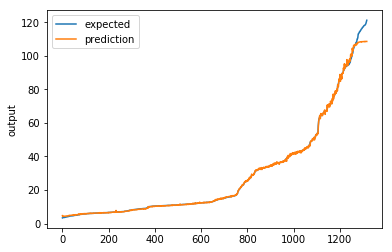

In [73]:
checkpointer = ModelCheckpoint(filepath="ann/best_weights_ann1.hdf5", verbose=0, save_best_only=True) # save best model
for i in range(5):
    model = Sequential()
    model.add(Dense(40, input_dim=x.shape[1], activation='sigmoid')) # Hidden 1
    model.add(Dense(25, activation='sigmoid')) # Hidden 2
    model.add(Dense(1)) # Output
    model.compile(loss='mean_squared_error', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=2, mode='auto')
    model.fit(x_train_ann, y_train_ann, validation_data=(x_test_ann,y_test_ann), callbacks=[monitor,checkpointer], verbose=2, epochs=100)  

model.load_weights('ann/best_weights_ann1.hdf5')
pred = model.predict(x_test_ann)
print_reg_eval(pred,y_test_ann)

Train on 3074 samples, validate on 1318 samples
Epoch 1/100
 - 12s - loss: 933.3481 - val_loss: 901.2054
Epoch 2/100
 - 1s - loss: 898.0924 - val_loss: 900.7303
Epoch 3/100
 - 1s - loss: 897.1731 - val_loss: 904.8927
Epoch 4/100
 - 1s - loss: 898.6919 - val_loss: 925.1552
Epoch 5/100
 - 1s - loss: 898.3629 - val_loss: 921.1817
Epoch 6/100
 - 0s - loss: 897.4560 - val_loss: 1005.2463
Epoch 7/100
 - 0s - loss: 897.6766 - val_loss: 896.8009
Epoch 8/100
 - 1s - loss: 898.2360 - val_loss: 895.9929
Epoch 9/100
 - 1s - loss: 897.0248 - val_loss: 933.9532
Epoch 10/100
 - 1s - loss: 897.3934 - val_loss: 894.5662
Epoch 11/100
 - 1s - loss: 894.8549 - val_loss: 944.7130
Epoch 12/100
 - 1s - loss: 898.3787 - val_loss: 966.5389
Epoch 13/100
 - 0s - loss: 899.4740 - val_loss: 1020.3993
Epoch 14/100
 - 1s - loss: 899.8708 - val_loss: 894.8661
Epoch 15/100
 - 1s - loss: 897.5982 - val_loss: 913.4255
Epoch 00015: early stopping
Train on 3074 samples, validate on 1318 samples
Epoch 1/100
 - 11s - loss: 

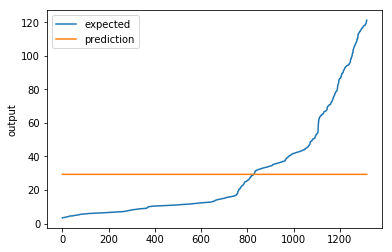

In [67]:
checkpointer = ModelCheckpoint(filepath="ann/best_weights_ann2.hdf5", verbose=0, save_best_only=True) # save best model
for i in range(5):
    model = Sequential()
    model.add(Dense(30, input_dim=x.shape[1], activation='sigmoid')) # Hidden 1
    model.add(Dense(20, activation='relu')) # Hidden 1
    model.add(Dense(10, activation='tanh')) # Hidden 2
    model.add(Dense(1)) # Output
    model.compile(loss='mean_squared_error', optimizer='sgd')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=2, mode='auto')
    model.fit(x_train_ann, y_train_ann, validation_data=(x_test_ann,y_test_ann), callbacks=[monitor,checkpointer], verbose=2, epochs=100)  

model.load_weights('ann/best_weights_ann2.hdf5')
pred = model.predict(x_test_ann)
print_reg_eval(pred,y_test_ann)

Train on 3074 samples, validate on 1318 samples
Epoch 1/100
 - 11s - loss: 1514.2518 - val_loss: 1317.6148
Epoch 2/100
 - 1s - loss: 1324.0663 - val_loss: 1213.6312
Epoch 3/100
 - 1s - loss: 1226.2782 - val_loss: 1134.5060
Epoch 4/100
 - 1s - loss: 1146.3774 - val_loss: 1067.4761
Epoch 5/100
 - 1s - loss: 1078.8987 - val_loss: 1012.8255
Epoch 6/100
 - 1s - loss: 1020.5376 - val_loss: 966.8157
Epoch 7/100
 - 1s - loss: 972.4808 - val_loss: 922.0522
Epoch 8/100
 - 1s - loss: 922.6053 - val_loss: 873.0929
Epoch 9/100
 - 1s - loss: 864.3278 - val_loss: 807.3473
Epoch 10/100
 - 1s - loss: 792.4313 - val_loss: 729.1037
Epoch 11/100
 - 0s - loss: 707.2269 - val_loss: 648.9443
Epoch 12/100
 - 1s - loss: 623.3368 - val_loss: 573.3287
Epoch 13/100
 - 1s - loss: 555.0962 - val_loss: 516.9073
Epoch 14/100
 - 1s - loss: 502.7777 - val_loss: 475.4662
Epoch 15/100
 - 1s - loss: 461.8789 - val_loss: 436.6476
Epoch 16/100
 - 1s - loss: 421.9262 - val_loss: 396.6141
Epoch 17/100
 - 1s - loss: 384.7700 -

 - 1s - loss: 1403.1759 - val_loss: 1283.8083
Epoch 3/100
 - 1s - loss: 1298.2266 - val_loss: 1194.9555
Epoch 4/100
 - 1s - loss: 1207.5500 - val_loss: 1118.7580
Epoch 5/100
 - 1s - loss: 1129.8285 - val_loss: 1052.8106
Epoch 6/100
 - 1s - loss: 1064.6923 - val_loss: 1002.0119
Epoch 7/100
 - 1s - loss: 1009.4417 - val_loss: 952.3775
Epoch 8/100
 - 1s - loss: 954.3434 - val_loss: 897.6145
Epoch 9/100
 - 1s - loss: 890.7196 - val_loss: 826.3955
Epoch 10/100
 - 1s - loss: 810.5614 - val_loss: 742.9737
Epoch 11/100
 - 1s - loss: 722.4984 - val_loss: 661.9396
Epoch 12/100
 - 1s - loss: 644.1276 - val_loss: 592.5345
Epoch 13/100
 - 1s - loss: 577.8079 - val_loss: 542.4968
Epoch 14/100
 - 1s - loss: 526.1207 - val_loss: 496.1168
Epoch 15/100
 - 1s - loss: 480.8393 - val_loss: 451.8289
Epoch 16/100
 - 1s - loss: 439.7475 - val_loss: 413.6174
Epoch 17/100
 - 1s - loss: 401.1007 - val_loss: 378.7678
Epoch 18/100
 - 1s - loss: 366.4961 - val_loss: 345.9321
Epoch 19/100
 - 1s - loss: 333.5807 - va

Epoch 62/100
 - 1s - loss: 0.3698 - val_loss: 0.3669
Epoch 63/100
 - 1s - loss: 0.3511 - val_loss: 0.3750
Epoch 64/100
 - 1s - loss: 0.3346 - val_loss: 0.4520
Epoch 65/100
 - 1s - loss: 0.3325 - val_loss: 0.2596
Epoch 66/100
 - 1s - loss: 0.3263 - val_loss: 0.4171
Epoch 67/100
 - 1s - loss: 0.3129 - val_loss: 0.5444
Epoch 68/100
 - 1s - loss: 0.3141 - val_loss: 0.5511
Epoch 69/100
 - 1s - loss: 0.3038 - val_loss: 0.3490
Epoch 70/100
 - 1s - loss: 0.3108 - val_loss: 0.4172
Epoch 00070: early stopping
Train on 3074 samples, validate on 1318 samples
Epoch 1/100
 - 12s - loss: 1509.9103 - val_loss: 1320.3246
Epoch 2/100
 - 1s - loss: 1328.9070 - val_loss: 1218.9629
Epoch 3/100
 - 1s - loss: 1231.2596 - val_loss: 1138.8828
Epoch 4/100
 - 1s - loss: 1150.7985 - val_loss: 1071.9114
Epoch 5/100
 - 1s - loss: 1082.1021 - val_loss: 1014.3128
Epoch 6/100
 - 1s - loss: 1022.8483 - val_loss: 967.4861
Epoch 7/100
 - 1s - loss: 971.8354 - val_loss: 920.5418
Epoch 8/100
 - 1s - loss: 919.2736 - val_lo

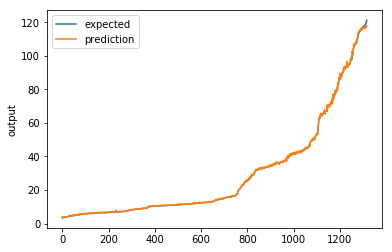

In [68]:
checkpointer = ModelCheckpoint(filepath="ann/best_weights_ann3.hdf5", verbose=0, save_best_only=True) # save best model
for i in range(5):
    model = Sequential()
    model.add(Dense(50, input_dim=x.shape[1], activation='sigmoid')) # Hidden 1
    model.add(Dense(25, activation='tanh')) # Hidden 2
    model.add(Dense(1)) # Output
    model.compile(loss='mean_squared_error', optimizer='rmsprop')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=2, mode='auto')
    model.fit(x_train_ann, y_train_ann, validation_data=(x_test_ann,y_test_ann), callbacks=[monitor,checkpointer], verbose=2, epochs=100)  

model.load_weights('ann/best_weights_ann3.hdf5')
pred = model.predict(x_test_ann)
print_reg_eval(pred,y_test_ann)

Train on 3074 samples, validate on 1318 samples
Epoch 1/100
 - 12s - loss: 227.3060 - val_loss: 40.2381
Epoch 2/100
 - 1s - loss: 26.8747 - val_loss: 8.3601
Epoch 3/100
 - 1s - loss: 4.4869 - val_loss: 52.6524
Epoch 4/100
 - 1s - loss: 4.8430 - val_loss: 1.1382
Epoch 5/100
 - 1s - loss: 4.4912 - val_loss: 2.9624
Epoch 6/100
 - 1s - loss: 3.2557 - val_loss: 12.3140
Epoch 7/100
 - 1s - loss: 1.3046 - val_loss: 3.8306
Epoch 8/100
 - 1s - loss: 2.5057 - val_loss: 1.0041
Epoch 9/100
 - 1s - loss: 1.5561 - val_loss: 6.6418
Epoch 10/100
 - 1s - loss: 0.9514 - val_loss: 1.0796
Epoch 11/100
 - 1s - loss: 1.2069 - val_loss: 0.7316
Epoch 12/100
 - 1s - loss: 0.5766 - val_loss: 4.2232
Epoch 13/100
 - 1s - loss: 0.6250 - val_loss: 1.6713
Epoch 14/100
 - 1s - loss: 0.4640 - val_loss: 0.9772
Epoch 15/100
 - 1s - loss: 1.4862 - val_loss: 4.7094
Epoch 16/100
 - 1s - loss: 0.7386 - val_loss: 2.1258
Epoch 00016: early stopping
Train on 3074 samples, validate on 1318 samples
Epoch 1/100
 - 12s - loss: 213

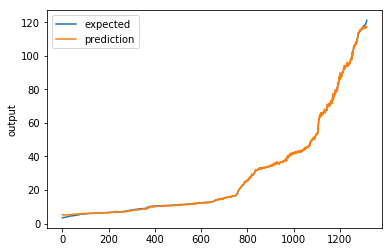

In [69]:
checkpointer = ModelCheckpoint(filepath="ann/best_weights_ann4.hdf5", verbose=0, save_best_only=True) # save best model
for i in range(5):
    model = Sequential()
    model.add(Dense(40, input_dim=x.shape[1], activation='relu')) # Hidden 1
    model.add(Dense(25, activation='sigmoid')) # Hidden 2
    model.add(Dense(1)) # Output
    model.compile(loss='mean_squared_error', optimizer='sgd')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=2, mode='auto')
    model.fit(x_train_ann, y_train_ann, validation_data=(x_test_ann,y_test_ann), callbacks=[monitor,checkpointer], verbose=2, epochs=100)  

model.load_weights('ann/best_weights_ann4.hdf5')
pred = model.predict(x_test_ann)
print_reg_eval(pred,y_test_ann)

Train on 3074 samples, validate on 1318 samples
Epoch 1/100
 - 12s - loss: 1789.1523 - val_loss: 1675.6612
Epoch 2/100
 - 1s - loss: 1742.3489 - val_loss: 1634.3385
Epoch 3/100
 - 1s - loss: 1700.6828 - val_loss: 1597.4681
Epoch 4/100
 - 1s - loss: 1664.4832 - val_loss: 1565.7800
Epoch 5/100
 - 1s - loss: 1632.5604 - val_loss: 1537.8022
Epoch 6/100
 - 1s - loss: 1604.6064 - val_loss: 1512.0291
Epoch 7/100
 - 1s - loss: 1578.0373 - val_loss: 1487.3286
Epoch 8/100
 - 1s - loss: 1552.2553 - val_loss: 1463.6718
Epoch 9/100
 - 1s - loss: 1525.9878 - val_loss: 1437.9038
Epoch 10/100
 - 1s - loss: 1497.0646 - val_loss: 1409.6637
Epoch 11/100
 - 1s - loss: 1466.4543 - val_loss: 1380.4392
Epoch 12/100
 - 1s - loss: 1436.0313 - val_loss: 1353.2525
Epoch 13/100
 - 1s - loss: 1408.4689 - val_loss: 1328.1398
Epoch 14/100
 - 1s - loss: 1381.7823 - val_loss: 1304.2275
Epoch 15/100
 - 1s - loss: 1356.6908 - val_loss: 1281.6471
Epoch 16/100
 - 1s - loss: 1331.8735 - val_loss: 1258.8510
Epoch 17/100
 - 

Epoch 42/100
 - 1s - loss: 804.5891 - val_loss: 771.0475
Epoch 43/100
 - 1s - loss: 788.5928 - val_loss: 756.2547
Epoch 44/100
 - 1s - loss: 772.8155 - val_loss: 741.7084
Epoch 45/100
 - 1s - loss: 757.1677 - val_loss: 727.2336
Epoch 46/100
 - 1s - loss: 741.8587 - val_loss: 713.1479
Epoch 47/100
 - 1s - loss: 727.2790 - val_loss: 699.2803
Epoch 48/100
 - 1s - loss: 712.7680 - val_loss: 686.1915
Epoch 49/100
 - 1s - loss: 698.3655 - val_loss: 672.8693
Epoch 50/100
 - 0s - loss: 684.6591 - val_loss: 659.8481
Epoch 51/100
 - 1s - loss: 670.8309 - val_loss: 646.9933
Epoch 52/100
 - 1s - loss: 657.3775 - val_loss: 634.5994
Epoch 53/100
 - 1s - loss: 644.0327 - val_loss: 622.0840
Epoch 54/100
 - 1s - loss: 630.9747 - val_loss: 610.0650
Epoch 55/100
 - 1s - loss: 618.3211 - val_loss: 598.1389
Epoch 56/100
 - 1s - loss: 605.7641 - val_loss: 586.4797
Epoch 57/100
 - 1s - loss: 593.6926 - val_loss: 575.2476
Epoch 58/100
 - 1s - loss: 581.7730 - val_loss: 564.0729
Epoch 59/100
 - 1s - loss: 570.

Epoch 84/100
 - 1s - loss: 361.3174 - val_loss: 353.7852
Epoch 85/100
 - 1s - loss: 353.6636 - val_loss: 346.5057
Epoch 86/100
 - 1s - loss: 346.3715 - val_loss: 339.1375
Epoch 87/100
 - 1s - loss: 339.4155 - val_loss: 332.5498
Epoch 88/100
 - 1s - loss: 332.0576 - val_loss: 325.2684
Epoch 89/100
 - 1s - loss: 325.2253 - val_loss: 318.8986
Epoch 90/100
 - 1s - loss: 318.2360 - val_loss: 311.8457
Epoch 91/100
 - 1s - loss: 311.4995 - val_loss: 305.4694
Epoch 92/100
 - 1s - loss: 304.6508 - val_loss: 298.9669
Epoch 93/100
 - 1s - loss: 298.2660 - val_loss: 292.3995
Epoch 94/100
 - 1s - loss: 292.1190 - val_loss: 286.5869
Epoch 95/100
 - 1s - loss: 285.8130 - val_loss: 280.5387
Epoch 96/100
 - 1s - loss: 279.5751 - val_loss: 274.4944
Epoch 97/100
 - 1s - loss: 273.6042 - val_loss: 268.6237
Epoch 98/100
 - 1s - loss: 267.5028 - val_loss: 262.6903
Epoch 99/100
 - 1s - loss: 261.7113 - val_loss: 256.9227
Epoch 100/100
 - 1s - loss: 255.6772 - val_loss: 250.9540
Train on 3074 samples, validat

 - 1s - loss: 1251.8221 - val_loss: 1186.2742
Epoch 25/100
 - 1s - loss: 1230.8861 - val_loss: 1167.1303
Epoch 26/100
 - 1s - loss: 1210.0135 - val_loss: 1147.8860
Epoch 27/100
 - 1s - loss: 1188.3902 - val_loss: 1127.5365
Epoch 28/100
 - 1s - loss: 1166.3667 - val_loss: 1106.4703
Epoch 29/100
 - 1s - loss: 1143.1931 - val_loss: 1083.8936
Epoch 30/100
 - 1s - loss: 1118.9315 - val_loss: 1060.0588
Epoch 31/100
 - 1s - loss: 1094.3921 - val_loss: 1038.2566
Epoch 32/100
 - 1s - loss: 1072.0617 - val_loss: 1017.7754
Epoch 33/100
 - 1s - loss: 1050.5805 - val_loss: 998.0262
Epoch 34/100
 - 1s - loss: 1030.2617 - val_loss: 979.7113
Epoch 35/100
 - 1s - loss: 1010.4596 - val_loss: 961.3604
Epoch 36/100
 - 1s - loss: 991.1667 - val_loss: 943.7253
Epoch 37/100
 - 1s - loss: 972.2683 - val_loss: 925.6698
Epoch 38/100
 - 1s - loss: 953.5734 - val_loss: 909.0584
Epoch 39/100
 - 1s - loss: 934.9358 - val_loss: 891.7216
Epoch 40/100
 - 1s - loss: 916.7923 - val_loss: 875.1865
Epoch 41/100
 - 1s - lo

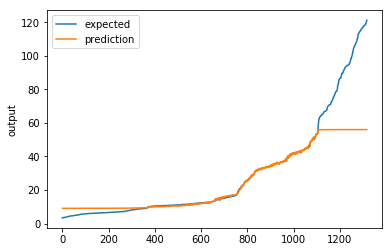

In [70]:
checkpointer = ModelCheckpoint(filepath="ann/best_weights_ann5.hdf5", verbose=0, save_best_only=True) # save best model
for i in range(5):
    model = Sequential()
    model.add(Dense(10, input_dim=x.shape[1], activation='tanh')) # Hidden 1
    model.add(Dense(5, activation='sigmoid')) # Hidden 2
    model.add(Dense(1)) # Output
    model.compile(loss='mean_squared_error', optimizer='rmsprop')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=2, mode='auto')
    model.fit(x_train_ann, y_train_ann, validation_data=(x_test_ann,y_test_ann), callbacks=[monitor,checkpointer], verbose=2, epochs=100)  

model.load_weights('ann/best_weights_ann5.hdf5')
pred = model.predict(x_test_ann)
print_reg_eval(pred,y_test_ann)

# Create x and y in the format RNN accepts

In [71]:
max = df['Close'].max()
min = df['Close'].min()
df['normalized_Close'] = (df['Close'] - min)/(max - min)

In [72]:
df.head()

,Close,normalized_Volume,normalized_Open,normalized_High,normalized_Low,normalized_Close
0,4.125000,0.075401,0.004378,0.006469,0.006934,0.007408
1,4.015625,0.019194,0.007031,0.006205,0.008535,0.006482
2,4.000000,0.005339,0.005970,0.005413,0.008135,0.006350
3,3.843750,0.036632,0.005970,0.005149,0.007201,0.005027
4,3.390625,0.167478,0.003714,0.002904,0.003334,0.001191


In [74]:
xarray=[]
xarray=df[['normalized_Open','normalized_High','normalized_Low','normalized_Volume','normalized_Close']].as_matrix()

C:\Users\rutwi\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [75]:
yarray=df[['Close']].as_matrix()

C:\Users\rutwi\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [76]:
SEQUENCE_SIZE = 7
import numpy as np

def to_sequences(seq_size, data,data2):
    x = []
    y = []

    for i in range(len(data)-SEQUENCE_SIZE-1):
        #print(i)
        window = data[i:(i+SEQUENCE_SIZE)]
        after_window = data2[i+SEQUENCE_SIZE]
        window = [[x] for x in window]
        #print("{} - {}".format(window,after_window))
        x.append(window)
        y.append(after_window)
        
    return np.array(x),np.array(y)

In [77]:
x,y = to_sequences(SEQUENCE_SIZE,xarray,yarray)

In [109]:
x.shape

(4392, 5)

In [110]:
y.shape

(4392,)

In [78]:
x_rnn = x.reshape(x.shape[0],7,5)

In [79]:
y_rnn = y.reshape(y.shape[0])

# LSTM - Ready to train a RNN model 

In [80]:
x_train_lstm = x_rnn[0:2800]
y_train_lstm = y_rnn[0:2800]
x_test_lstm = x_rnn[2800:4385]
y_test_lstm = y_rnn[2800:4385]

Build model...
Train...
Train on 2800 samples, validate on 1584 samples
Epoch 1/10
 - 16s - loss: 87.8405 - val_loss: 1133.8705
Epoch 2/10
 - 2s - loss: 4.8821 - val_loss: 1076.7902
Epoch 3/10
 - 2s - loss: 4.5971 - val_loss: 1022.4747
Epoch 4/10
 - 2s - loss: 4.3234 - val_loss: 1032.3103
Epoch 5/10
 - 2s - loss: 3.7349 - val_loss: 989.4287
Epoch 6/10
 - 2s - loss: 4.1405 - val_loss: 978.5062
Epoch 7/10
 - 2s - loss: 3.8402 - val_loss: 984.3268
Epoch 8/10
 - 2s - loss: 3.5076 - val_loss: 966.9412
Epoch 9/10
 - 2s - loss: 3.5699 - val_loss: 973.3150
Epoch 10/10
 - 2s - loss: 3.4559 - val_loss: 953.7929
Train...
Train on 2800 samples, validate on 1584 samples
Epoch 1/10
 - 16s - loss: 88.8006 - val_loss: 1236.6999
Epoch 2/10
 - 2s - loss: 5.2400 - val_loss: 1100.2251
Epoch 3/10
 - 3s - loss: 4.9576 - val_loss: 1057.4071
Epoch 4/10
 - 3s - loss: 5.2336 - val_loss: 1044.3947
Epoch 5/10
 - 3s - loss: 4.3336 - val_loss: 1034.6589
Epoch 6/10
 - 2s - loss: 3.7296 - val_loss: 993.8697
Epoch 7/1

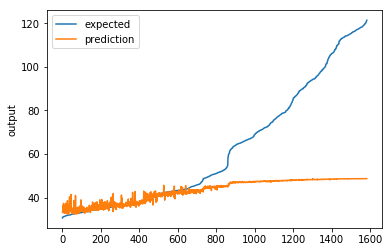

In [81]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import numpy as np

checkpointer = ModelCheckpoint(filepath="lstm/best_weights_lstm.hdf5", verbose=0, save_best_only=True) # save best model

print('Build model...')
for i in range(5):
    model = Sequential()
    model.add(LSTM(64, dropout=0.1, recurrent_dropout=0.1, input_shape=(7, 5)))
    model.add(Dense(32))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    print('Train...')
    model.fit(x_train_lstm,y_train_lstm,validation_data=(x_test_lstm,y_test_lstm),callbacks=[monitor,checkpointer],verbose=2, epochs=10)
    
model.load_weights('lstm/best_weights_lstm.hdf5')
pred = model.predict(x_test_lstm)
print_reg_eval(pred,y_test_lstm)

# Hypertuning on parameters for LSTM

Train...
Train on 2800 samples, validate on 1584 samples
Epoch 1/10
 - 10s - loss: 46.3747 - val_loss: 534.6283
Epoch 2/10
 - 1s - loss: 8.8839 - val_loss: 745.5555
Epoch 3/10
 - 1s - loss: 5.6396 - val_loss: 938.8243
Epoch 4/10
 - 1s - loss: 5.2513 - val_loss: 799.9011
Epoch 5/10
 - 1s - loss: 5.6574 - val_loss: 887.6865
Epoch 6/10
 - 1s - loss: 4.0105 - val_loss: 747.9506
Epoch 00006: early stopping
Train...
Train on 2800 samples, validate on 1584 samples
Epoch 1/10
 - 10s - loss: 53.7728 - val_loss: 653.7888
Epoch 2/10
 - 1s - loss: 6.9951 - val_loss: 542.2747
Epoch 3/10
 - 1s - loss: 5.5605 - val_loss: 590.5146
Epoch 4/10
 - 1s - loss: 6.4078 - val_loss: 650.8776
Epoch 5/10
 - 1s - loss: 7.1307 - val_loss: 551.3700
Epoch 6/10
 - 1s - loss: 5.6965 - val_loss: 696.9398
Epoch 7/10
 - 1s - loss: 5.4104 - val_loss: 664.0322
Epoch 00007: early stopping
Train...
Train on 2800 samples, validate on 1584 samples
Epoch 1/10
 - 10s - loss: 48.1005 - val_loss: 851.1733
Epoch 2/10
 - 1s - loss: 

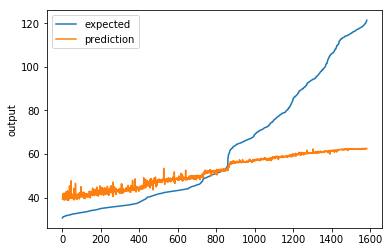

In [82]:
checkpointer = ModelCheckpoint(filepath="lstm/best_weights_lstm1.hdf5", verbose=0, save_best_only=True)
for i in range(5):
    model = Sequential()
    model.add(LSTM(64, dropout=0.1, recurrent_dropout=0.1, input_shape=(7, 5)))
    model.add(Dense(32))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='sgd')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    print('Train...')
    model.fit(x_train_lstm,y_train_lstm,validation_data=(x_test_lstm,y_test_lstm),callbacks=[monitor,checkpointer],verbose=2, epochs=10)
    
model.load_weights('lstm/best_weights_lstm1.hdf5')
pred = model.predict(x_test_lstm)
print_reg_eval(pred,y_test_lstm)

Train...
Train on 2800 samples, validate on 1584 samples
Epoch 1/10
 - 12s - loss: 49.6409 - val_loss: 1228.0238
Epoch 2/10
 - 1s - loss: 5.3401 - val_loss: 1022.8982
Epoch 3/10
 - 1s - loss: 4.9024 - val_loss: 1019.1457
Epoch 4/10
 - 2s - loss: 5.1607 - val_loss: 1029.2810
Epoch 5/10
 - 1s - loss: 4.2000 - val_loss: 1083.1531
Epoch 6/10
 - 2s - loss: 4.5902 - val_loss: 1011.8212
Epoch 7/10
 - 1s - loss: 4.4910 - val_loss: 1040.3321
Epoch 8/10
 - 1s - loss: 3.5129 - val_loss: 986.0209
Epoch 9/10
 - 1s - loss: 3.9525 - val_loss: 1008.3731
Epoch 10/10
 - 1s - loss: 4.4001 - val_loss: 970.8472
Train...
Train on 2800 samples, validate on 1584 samples
Epoch 1/10
 - 11s - loss: 43.8049 - val_loss: 1217.8287
Epoch 2/10
 - 1s - loss: 5.2540 - val_loss: 1065.3722
Epoch 3/10
 - 1s - loss: 5.2647 - val_loss: 1036.8230
Epoch 4/10
 - 1s - loss: 5.7294 - val_loss: 1075.8585
Epoch 5/10
 - 1s - loss: 4.1890 - val_loss: 1001.4239
Epoch 6/10
 - 1s - loss: 4.2031 - val_loss: 1006.5641
Epoch 7/10
 - 1s - 

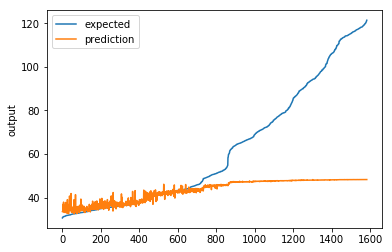

In [83]:
checkpointer = ModelCheckpoint(filepath="lstm/best_weights_lstm2.hdf5", verbose=0, save_best_only=True)
for i in range(5):
    model = Sequential()
    model.add(LSTM(64, dropout=0.1, recurrent_dropout=0.1, input_shape=(7, 5)))
    model.add(Dense(32))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='rmsprop')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    print('Train...')
    model.fit(x_train_lstm,y_train_lstm,validation_data=(x_test_lstm,y_test_lstm),callbacks=[monitor,checkpointer],verbose=2, epochs=10)
    
model.load_weights('lstm/best_weights_lstm2.hdf5')
pred = model.predict(x_test_lstm)
print_reg_eval(pred,y_test_lstm)

Train...
Train on 2800 samples, validate on 1584 samples
Epoch 1/10
 - 11s - loss: 98.1986 - val_loss: 1419.6548
Epoch 2/10
 - 2s - loss: 5.1801 - val_loss: 1131.6544
Epoch 3/10
 - 2s - loss: 4.3882 - val_loss: 1049.0399
Epoch 4/10
 - 1s - loss: 4.4514 - val_loss: 1047.4409
Epoch 5/10
 - 1s - loss: 4.3481 - val_loss: 1041.1313
Epoch 6/10
 - 2s - loss: 3.6812 - val_loss: 1013.0140
Epoch 7/10
 - 2s - loss: 3.9484 - val_loss: 1003.1427
Epoch 8/10
 - 2s - loss: 3.6845 - val_loss: 991.9650
Epoch 9/10
 - 2s - loss: 3.7975 - val_loss: 977.7888
Epoch 10/10
 - 2s - loss: 3.6836 - val_loss: 965.2730
Train...
Train on 2800 samples, validate on 1584 samples
Epoch 1/10
 - 12s - loss: 85.9664 - val_loss: 1197.9094
Epoch 2/10
 - 2s - loss: 5.1552 - val_loss: 1071.0958
Epoch 3/10
 - 2s - loss: 4.4685 - val_loss: 1027.7120
Epoch 4/10
 - 2s - loss: 4.1677 - val_loss: 986.0613
Epoch 5/10
 - 2s - loss: 4.8138 - val_loss: 984.6254
Epoch 6/10
 - 2s - loss: 4.4019 - val_loss: 999.3683
Epoch 7/10
 - 2s - loss

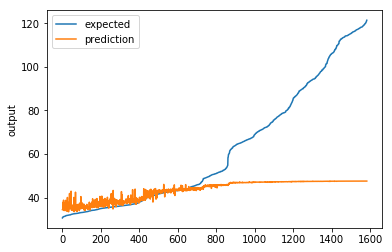

In [84]:
checkpointer = ModelCheckpoint(filepath="lstm/best_weights_lstm3.hdf5", verbose=0, save_best_only=True)
for i in range(5):
    model = Sequential()
    model.add(LSTM(64, dropout=0.1, recurrent_dropout=0.1, input_shape=(7, 5)))
    model.add(Dense(32))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    print('Train...')
    model.fit(x_train_lstm,y_train_lstm,validation_data=(x_test_lstm,y_test_lstm),callbacks=[monitor,checkpointer],verbose=2, epochs=10)
    
model.load_weights('lstm/best_weights_lstm3.hdf5')
pred = model.predict(x_test_lstm)
print_reg_eval(pred,y_test_lstm)

Train...
Train on 2800 samples, validate on 1584 samples
Epoch 1/10
 - 18s - loss: 30.1794 - val_loss: 1077.5039
Epoch 2/10
 - 7s - loss: 6.4380 - val_loss: 995.5998
Epoch 3/10
 - 7s - loss: 6.0332 - val_loss: 1018.5210
Epoch 4/10
 - 7s - loss: 6.0361 - val_loss: 968.5552
Epoch 5/10
 - 7s - loss: 5.2845 - val_loss: 943.9713
Epoch 6/10
 - 7s - loss: 5.1502 - val_loss: 1029.0605
Epoch 7/10
 - 7s - loss: 4.9541 - val_loss: 1041.0553
Epoch 8/10
 - 7s - loss: 4.9695 - val_loss: 975.8887
Epoch 9/10
 - 7s - loss: 4.9996 - val_loss: 1024.2641
Epoch 10/10
 - 7s - loss: 4.0945 - val_loss: 1018.0446
Epoch 00010: early stopping
Train...
Train on 2800 samples, validate on 1584 samples
Epoch 1/10
 - 18s - loss: 25.9538 - val_loss: 1102.2370
Epoch 2/10
 - 7s - loss: 6.2421 - val_loss: 1149.2263
Epoch 3/10
 - 7s - loss: 6.2448 - val_loss: 996.8773
Epoch 4/10
 - 7s - loss: 5.7981 - val_loss: 1110.8156
Epoch 5/10
 - 7s - loss: 5.8863 - val_loss: 1005.8765
Epoch 6/10
 - 7s - loss: 5.4188 - val_loss: 1015

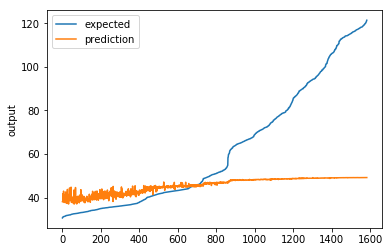

In [85]:
checkpointer = ModelCheckpoint(filepath="lstm/best_weights_lstm4.hdf5", verbose=0, save_best_only=True)
for i in range(5):
    model = Sequential()
    model.add(LSTM(128, dropout=0.1, recurrent_dropout=0.1, input_shape=(7, 5)))
    model.add(Dense(32))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='rmsprop')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    print('Train...')
    model.fit(x_train_lstm,y_train_lstm,validation_data=(x_test_lstm,y_test_lstm),callbacks=[monitor,checkpointer],verbose=2, epochs=10)
    
model.load_weights('lstm/best_weights_lstm4.hdf5')
pred = model.predict(x_test_lstm)
print_reg_eval(pred,y_test_lstm)

Train...
Train on 2800 samples, validate on 1584 samples
Epoch 1/10
 - 14s - loss: 49.4108 - val_loss: 604.4898
Epoch 2/10
 - 2s - loss: 8.0471 - val_loss: 826.6287
Epoch 3/10
 - 2s - loss: 6.5764 - val_loss: 769.6602
Epoch 4/10
 - 2s - loss: 5.9276 - val_loss: 802.5183
Epoch 5/10
 - 2s - loss: 6.0855 - val_loss: 723.1458
Epoch 6/10
 - 2s - loss: 4.8248 - val_loss: 831.0427
Epoch 00006: early stopping
Train...
Train on 2800 samples, validate on 1584 samples
Epoch 1/10
 - 14s - loss: 61.6693 - val_loss: 887.7311
Epoch 2/10
 - 2s - loss: 8.1979 - val_loss: 717.6563
Epoch 3/10
 - 2s - loss: 6.7910 - val_loss: 779.5050
Epoch 4/10
 - 2s - loss: 5.3168 - val_loss: 771.6788
Epoch 5/10
 - 2s - loss: 5.2861 - val_loss: 786.4303
Epoch 6/10
 - 2s - loss: 5.9957 - val_loss: 618.9173
Epoch 7/10
 - 2s - loss: 5.1331 - val_loss: 708.3192
Epoch 8/10
 - 2s - loss: 4.3700 - val_loss: 575.7459
Epoch 9/10
 - 2s - loss: 4.7208 - val_loss: 680.1690
Epoch 10/10
 - 2s - loss: 5.0113 - val_loss: 657.2767
Train

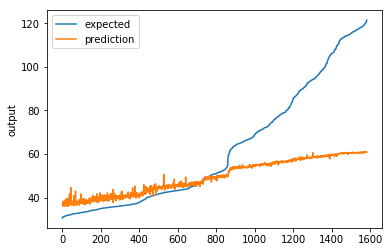

In [86]:
checkpointer = ModelCheckpoint(filepath="lstm/best_weights_lstm5.hdf5", verbose=0, save_best_only=True)
for i in range(5):
    model = Sequential()
    model.add(LSTM(64, dropout=0.1, recurrent_dropout=0.1, input_shape=(7, 5)))
    model.add(Dense(16))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='sgd')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    print('Train...')
    model.fit(x_train_lstm,y_train_lstm,validation_data=(x_test_lstm,y_test_lstm),callbacks=[monitor,checkpointer],verbose=2, epochs=10)
    
model.load_weights('lstm/best_weights_lstm5.hdf5')
pred = model.predict(x_test_lstm)
print_reg_eval(pred,y_test_lstm)

Train...
Train on 2800 samples, validate on 1584 samples
Epoch 1/10
 - 14s - loss: 105.7287 - val_loss: 2098.0982
Epoch 2/10
 - 1s - loss: 9.4116 - val_loss: 1318.8431
Epoch 3/10
 - 1s - loss: 5.0300 - val_loss: 1138.1357
Epoch 4/10
 - 1s - loss: 4.6705 - val_loss: 1054.8292
Epoch 5/10
 - 1s - loss: 4.5474 - val_loss: 1041.6853
Epoch 6/10
 - 1s - loss: 4.7966 - val_loss: 1034.6267
Epoch 7/10
 - 1s - loss: 3.6049 - val_loss: 1026.5922
Epoch 8/10
 - 1s - loss: 3.9290 - val_loss: 1000.0908
Epoch 9/10
 - 1s - loss: 3.8085 - val_loss: 982.0534
Epoch 10/10
 - 1s - loss: 3.5104 - val_loss: 959.3183
Train...
Train on 2800 samples, validate on 1584 samples
Epoch 1/10
 - 15s - loss: 104.0883 - val_loss: 2170.4859
Epoch 2/10
 - 1s - loss: 9.7966 - val_loss: 1301.0200
Epoch 3/10
 - 1s - loss: 5.1852 - val_loss: 1131.8610
Epoch 4/10
 - 1s - loss: 5.0393 - val_loss: 1062.4771
Epoch 5/10
 - 1s - loss: 3.9950 - val_loss: 1044.1449
Epoch 6/10
 - 1s - loss: 4.0773 - val_loss: 1041.3603
Epoch 7/10
 - 1s 

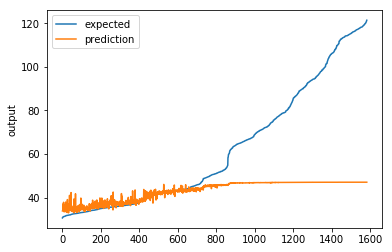

In [87]:
checkpointer = ModelCheckpoint(filepath="lstm/best_weights_lstm6.hdf5", verbose=0, save_best_only=True)
for i in range(5):
    model = Sequential()
    model.add(LSTM(32, dropout=0.1, recurrent_dropout=0.1, input_shape=(7, 5)))
    model.add(Dense(16))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='rmsprop')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    print('Train...')
    model.fit(x_train_lstm,y_train_lstm,validation_data=(x_test_lstm,y_test_lstm),callbacks=[monitor,checkpointer],verbose=2, epochs=10)
    
model.load_weights('lstm/best_weights_lstm6.hdf5')
pred = model.predict(x_test_lstm)
print_reg_eval(pred,y_test_lstm)

# CNN

In [88]:
x_cnn = x.reshape(x.shape[0],1,7,5)

In [89]:
y_cnn = y.reshape(y.shape[0])

In [90]:
x_train_cnn = x_cnn[0:2800]
y_train_cnn = y_cnn[0:2800]
x_test_cnn = x_cnn[2800:4385]
y_test_cnn = y_cnn[2800:4385]

Train on 2800 samples, validate on 1584 samples
Epoch 1/10
2800/2800 [==============================] - 24s 9ms/step - loss: 52.8562 - val_loss: 206.0467
Epoch 2/10
2800/2800 [==============================] - 7s 2ms/step - loss: 1.6114 - val_loss: 212.2940
Epoch 3/10
2800/2800 [==============================] - 6s 2ms/step - loss: 1.6636 - val_loss: 208.8294
Epoch 4/10
2800/2800 [==============================] - 5s 2ms/step - loss: 1.4479 - val_loss: 210.2269
Epoch 5/10
2800/2800 [==============================] - 5s 2ms/step - loss: 1.4977 - val_loss: 164.0968
Epoch 6/10
2800/2800 [==============================] - 6s 2ms/step - loss: 1.4560 - val_loss: 157.6531
Epoch 7/10
2800/2800 [==============================] - 7s 2ms/step - loss: 1.5491 - val_loss: 160.4027
Epoch 8/10
2800/2800 [==============================] - 8s 3ms/step - loss: 1.6447 - val_loss: 140.4710
Epoch 9/10
2800/2800 [==============================] - 7s 2ms/step - loss: 1.3202 - val_loss: 110.1931
Epoch 10/10
28

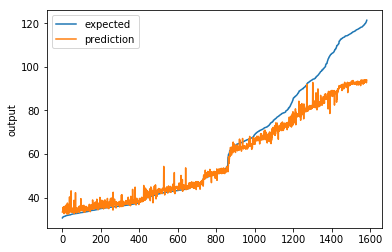

In [102]:
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
batch_size = 32
checkpointer = ModelCheckpoint(filepath="cnn/best_weights_cnn.hdf5", verbose=0, save_best_only=True) # save best model

for i in range(4):
    model = Sequential()
    input_shape = (1, 7, 5)
    model.add(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same',activation='relu',input_shape=input_shape)) 
    model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
    model.add(Conv2D(128, (3, 3), padding='same', activation='tanh'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None,padding='same'))
    #model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    #model.summary()
    model.compile(loss="mean_squared_error", optimizer="adam")
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience =5, verbose=2, mode='auto')
    model.fit(x_train_cnn, y_train_cnn,batch_size=batch_size,epochs=10,verbose=1,validation_data=(x_test_cnn, y_test_cnn),callbacks=[monitor,checkpointer])

model.load_weights('cnn/best_weights_cnn.hdf5') 
pred = model.predict(x_test_cnn)
print_reg_eval(pred,y_test_cnn)

# Hypertuning on parameters for CNN

Train on 2800 samples, validate on 1584 samples
Epoch 1/10
2800/2800 [==============================] - 17s 6ms/step - loss: 123.9775 - val_loss: 1292.4278
Epoch 2/10
2800/2800 [==============================] - 2s 680us/step - loss: 11.4904 - val_loss: 1042.5059
Epoch 3/10
2800/2800 [==============================] - 2s 682us/step - loss: 6.8621 - val_loss: 845.4055
Epoch 4/10
2800/2800 [==============================] - 2s 685us/step - loss: 6.1270 - val_loss: 738.1369
Epoch 5/10
2800/2800 [==============================] - 2s 682us/step - loss: 5.6477 - val_loss: 658.9704
Epoch 6/10
2800/2800 [==============================] - 2s 683us/step - loss: 5.5299 - val_loss: 598.3213
Epoch 7/10
2800/2800 [==============================] - 2s 680us/step - loss: 4.9846 - val_loss: 571.6679
Epoch 8/10
2800/2800 [==============================] - 2s 684us/step - loss: 4.9723 - val_loss: 536.5818
Epoch 9/10
2800/2800 [==============================] - 2s 680us/step - loss: 4.7139 - val_loss: 506

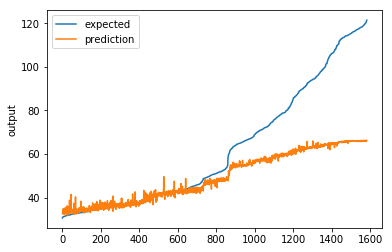

In [103]:
batch_size = 64
checkpointer = ModelCheckpoint(filepath="cnn/best_weights_cnn1.hdf5", verbose=0, save_best_only=True) # save best model

for i in range(4):
    model = Sequential()
    input_shape = (1, 7, 5)
    model.add(Conv2D(32, kernel_size=(3, 9), strides=(1, 1), padding='same',activation='relu',input_shape=input_shape)) 
    model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
    model.add(Conv2D(64, (3, 9), padding='same', activation='tanh'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None,padding='same'))
    #model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    #model.summary()
    model.compile(loss="mean_squared_error", optimizer="adam")
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience =5, verbose=2, mode='auto')
    model.fit(x_train_cnn, y_train_cnn,batch_size=batch_size,epochs=10,verbose=1,validation_data=(x_test_cnn, y_test_cnn),callbacks=[monitor,checkpointer])

model.load_weights('cnn/best_weights_cnn1.hdf5') 
pred = model.predict(x_test_cnn)
print_reg_eval(pred,y_test_cnn)

Train on 2800 samples, validate on 1584 samples
Epoch 1/10
2800/2800 [==============================] - 18s 6ms/step - loss: 96.1328 - val_loss: 710.0832
Epoch 2/10
2800/2800 [==============================] - 1s 499us/step - loss: 4.6538 - val_loss: 505.1014
Epoch 3/10
2800/2800 [==============================] - 1s 499us/step - loss: 2.4544 - val_loss: 453.5351
Epoch 4/10
2800/2800 [==============================] - 1s 500us/step - loss: 2.4032 - val_loss: 305.1675
Epoch 5/10
2800/2800 [==============================] - 1s 498us/step - loss: 2.4588 - val_loss: 308.8400
Epoch 6/10
2800/2800 [==============================] - 1s 505us/step - loss: 2.2393 - val_loss: 361.9315
Epoch 7/10
2800/2800 [==============================] - 1s 498us/step - loss: 2.3813 - val_loss: 385.5684
Epoch 8/10
2800/2800 [==============================] - 1s 504us/step - loss: 2.0309 - val_loss: 345.3806
Epoch 9/10
2800/2800 [==============================] - 1s 507us/step - loss: 1.9763 - val_loss: 390.708

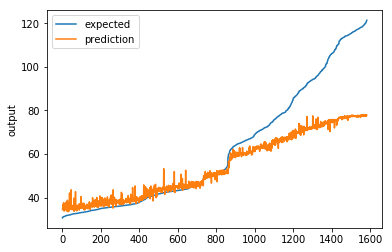

In [104]:
batch_size = 128
checkpointer = ModelCheckpoint(filepath="cnn/best_weights_cnn2.hdf5", verbose=0, save_best_only=True) # save best model

for i in range(4):
    model = Sequential()
    input_shape = (1, 7, 5)
    model.add(Conv2D(32, kernel_size=(3, 5), strides=(1, 1), padding='same',activation='relu',input_shape=input_shape)) 
    model.add(MaxPooling2D(pool_size=(2,3),padding='same'))
    model.add(Conv2D(128, (3, 5), padding='same', activation='tanh'))
    model.add(MaxPooling2D(pool_size=(2, 5), strides=None,padding='same'))
    #model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    #model.summary()
    model.compile(loss="mean_squared_error", optimizer="rmsprop")
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience =5, verbose=2, mode='auto')
    model.fit(x_train_cnn, y_train_cnn,batch_size=batch_size,epochs=10,verbose=1,validation_data=(x_test_cnn, y_test_cnn),callbacks=[monitor,checkpointer])

model.load_weights('cnn/best_weights_cnn2.hdf5') 
pred = model.predict(x_test_cnn)
print_reg_eval(pred,y_test_cnn)

Train on 2800 samples, validate on 1584 samples
Epoch 1/10
2800/2800 [==============================] - 19s 7ms/step - loss: nan - val_loss: nan
Epoch 2/10
 160/2800 [>.............................] - ETA: 3s - loss: nan

C:\Users\rutwi\Anaconda3\lib\site-packages\keras\callbacks.py:538: RuntimeWarning: invalid value encountered in less
  if self.monitor_op(current - self.min_delta, self.best):
C:\Users\rutwi\Anaconda3\lib\site-packages\keras\callbacks.py:434: RuntimeWarning: invalid value encountered in less
  if self.monitor_op(current, self.best):


2800/2800 [==============================] - 4s 1ms/step - loss: nan - val_loss: nan
Epoch 3/10
2800/2800 [==============================] - 3s 1ms/step - loss: nan - val_loss: nan
Epoch 4/10
2800/2800 [==============================] - 4s 1ms/step - loss: nan - val_loss: nan
Epoch 5/10
2800/2800 [==============================] - 4s 1ms/step - loss: nan - val_loss: nan
Epoch 00005: early stopping
Train on 2800 samples, validate on 1584 samples
Epoch 1/10
2800/2800 [==============================] - 20s 7ms/step - loss: nan - val_loss: nan
Epoch 2/10
2800/2800 [==============================] - 4s 1ms/step - loss: nan - val_loss: nan
Epoch 3/10
2800/2800 [==============================] - 4s 1ms/step - loss: nan - val_loss: nan
Epoch 4/10
2800/2800 [==============================] - 4s 1ms/step - loss: nan - val_loss: nan
Epoch 5/10
2800/2800 [==============================] - 4s 1ms/step - loss: nan - val_loss: nan
Epoch 00005: early stopping
Train on 2800 samples, validate on 1584 sa

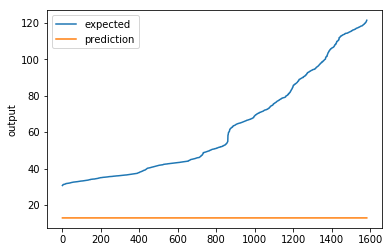

In [105]:
batch_size = 32
checkpointer = ModelCheckpoint(filepath="cnn/best_weights_cnn3.hdf5", verbose=0, save_best_only=True) # save best model

for i in range(4):
    model = Sequential()
    input_shape = (1, 7, 5)
    model.add(Conv2D(32, kernel_size=(3, 4), strides=(1, 1), padding='same',activation='relu',input_shape=input_shape)) 
    model.add(MaxPooling2D(pool_size=(2,4),padding='same'))
    model.add(Conv2D(128, (3, 4), padding='same', activation='sigmoid'))
    model.add(MaxPooling2D(pool_size=(2,4), strides=None,padding='same'))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(1))
    #model.summary()
    model.compile(loss="mean_squared_error", optimizer="sgd")
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience =5, verbose=2, mode='auto')
    model.fit(x_train_cnn, y_train_cnn,batch_size=batch_size,epochs=10,verbose=1,validation_data=(x_test_cnn, y_test_cnn),callbacks=[monitor,checkpointer])

model.load_weights('cnn/best_weights_cnn3.hdf5') 
pred = model.predict(x_test_cnn)
print_reg_eval(pred,y_test_cnn)

Train on 2800 samples, validate on 1584 samples
Epoch 1/10
2800/2800 [==============================] - 20s 7ms/step - loss: 85.9425 - val_loss: 2524.5664
Epoch 2/10
2800/2800 [==============================] - 3s 1ms/step - loss: 38.9714 - val_loss: 2330.5459
Epoch 3/10
2800/2800 [==============================] - 3s 1ms/step - loss: 24.9537 - val_loss: 1821.1235
Epoch 4/10
2800/2800 [==============================] - 3s 1ms/step - loss: 11.8688 - val_loss: 1443.3965
Epoch 5/10
2800/2800 [==============================] - 3s 1ms/step - loss: 5.5421 - val_loss: 1262.9137
Epoch 6/10
2800/2800 [==============================] - 3s 1ms/step - loss: 3.4517 - val_loss: 1160.5451
Epoch 7/10
2800/2800 [==============================] - 3s 1ms/step - loss: 2.3334 - val_loss: 1043.1322
Epoch 8/10
2800/2800 [==============================] - 3s 1ms/step - loss: 1.9914 - val_loss: 974.4821
Epoch 9/10
2800/2800 [==============================] - 3s 1ms/step - loss: 1.7727 - val_loss: 926.8707
Epoc

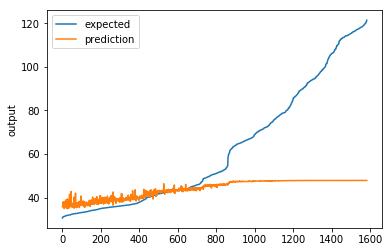

In [106]:
batch_size = 64
checkpointer = ModelCheckpoint(filepath="cnn/best_weights_cnn4.hdf5", verbose=0, save_best_only=True) # save best model

for i in range(4):
    model = Sequential()
    input_shape = (1, 7, 5)
    model.add(Conv2D(64, kernel_size=(3, 7), strides=(1, 1), padding='same',activation='relu',input_shape=input_shape)) 
    model.add(MaxPooling2D(pool_size=(2,5),padding='same'))
    model.add(Conv2D(128, (3, 7), padding='same', activation='sigmoid'))
    model.add(MaxPooling2D(pool_size=(2, 5), strides=None,padding='same'))
    #model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    #model.summary()
    model.compile(loss="mean_squared_error", optimizer="adam")
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience =5, verbose=2, mode='auto')
    model.fit(x_train_cnn, y_train_cnn,batch_size=batch_size,epochs=10,verbose=1,validation_data=(x_test_cnn, y_test_cnn),callbacks=[monitor,checkpointer])

model.load_weights('cnn/best_weights_cnn4.hdf5') 
pred = model.predict(x_test_cnn)
print_reg_eval(pred,y_test_cnn)

Train on 2800 samples, validate on 1584 samples
Epoch 1/10
2800/2800 [==============================] - 20s 7ms/step - loss: nan - val_loss: nan
Epoch 2/10
 192/2800 [=>............................] - ETA: 2s - loss: nan

C:\Users\rutwi\Anaconda3\lib\site-packages\keras\callbacks.py:538: RuntimeWarning: invalid value encountered in less
  if self.monitor_op(current - self.min_delta, self.best):
C:\Users\rutwi\Anaconda3\lib\site-packages\keras\callbacks.py:434: RuntimeWarning: invalid value encountered in less
  if self.monitor_op(current, self.best):


2800/2800 [==============================] - 3s 1ms/step - loss: nan - val_loss: nan
Epoch 3/10
2800/2800 [==============================] - 3s 1ms/step - loss: nan - val_loss: nan
Epoch 4/10
2800/2800 [==============================] - 3s 1ms/step - loss: nan - val_loss: nan
Epoch 5/10
2800/2800 [==============================] - 3s 1ms/step - loss: nan - val_loss: nan
Epoch 00005: early stopping
Train on 2800 samples, validate on 1584 samples
Epoch 1/10
2800/2800 [==============================] - 20s 7ms/step - loss: 68.8817 - val_loss: 2577.5319
Epoch 2/10
2800/2800 [==============================] - 3s 1ms/step - loss: 21.5382 - val_loss: 565.7245
Epoch 3/10
2800/2800 [==============================] - 3s 1ms/step - loss: 38.9797 - val_loss: 1446.6264
Epoch 4/10
2800/2800 [==============================] - 3s 1ms/step - loss: 38800525380050646702799978496.0000 - val_loss: 459837447896891761736286208.0000
Epoch 5/10
2800/2800 [==============================] - 3s 1ms/step - loss: 2

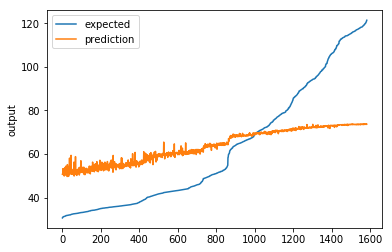

In [107]:
batch_size = 64
checkpointer = ModelCheckpoint(filepath="cnn/best_weights_cnn5.hdf5", verbose=0, save_best_only=True) # save best model

for i in range(4):
    model = Sequential()
    input_shape = (1, 7, 5)
    model.add(Conv2D(64, kernel_size=(3, 5), strides=(1, 1), padding='same',activation='relu',input_shape=input_shape)) 
    model.add(MaxPooling2D(pool_size=(2,5),padding='same'))
    model.add(Conv2D(256, (3, 5), padding='same', activation='tanh'))
    model.add(MaxPooling2D(pool_size=(2, 5), strides=None,padding='same'))
    #model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    #model.summary()
    model.compile(loss="mean_squared_error", optimizer="sgd")
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience =5, verbose=2, mode='auto')
    model.fit(x_train_cnn, y_train_cnn,batch_size=batch_size,epochs=10,verbose=1,validation_data=(x_test_cnn, y_test_cnn),callbacks=[monitor,checkpointer])

model.load_weights('cnn/best_weights_cnn5.hdf5') 
pred = model.predict(x_test_cnn)
print_reg_eval(pred,y_test_cnn)